# Load Checkpoint

In [1]:
from lib.utils import load_config
from lib.models.siamese import Siamese
from pathlib import Path

cfg = load_config()
path = Path(cfg.checkpoint_path, "shapenet_chairs_sketch_large.ckpt")
model = Siamese.load_from_checkpoint(path)

In [2]:
from lib.data.dataset import ShapeNetDatasetPreLoadPreTransform 
dataset = ShapeNetDatasetPreLoadPreTransform(cfg=cfg, stage="train") 

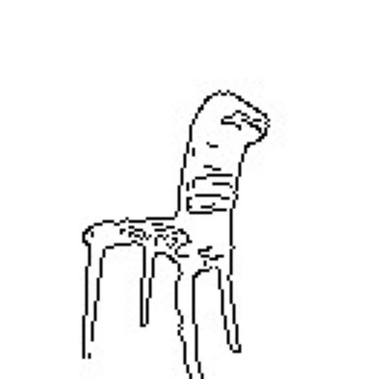

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def show_sketch(dataset, idx):
    image_data = np.transpose(dataset[idx]['sketch'], (1, 2, 0))
    # Ensure the image data is in the range [0, 1]
    image_data = np.clip(image_data, 0, 1)
    # Display the image
    plt.imshow(image_data)
    plt.axis('off')  # Optional: Turn off axis labels
    plt.show()

show_sketch(dataset, 10)

In [4]:
import torch
import faiss

def get_rendered_images(dataset):
    def _generator():
        for obj_id, obj in dataset.data.items():
            yield from dataset.data[obj_id]['images'].values()
    return torch.stack(list(_generator()))

def get_sketches(dataset):
    def _generator():
        for obj_id, obj in dataset.data.items():
            yield from dataset.data[obj_id]['sketches'].values()
    return torch.stack(list(_generator()))


# embedd the sketches
sketches= get_sketches(dataset) 
sketches_emb = model.decoder(sketches).detach().cpu().numpy()

# embedd the rendered images
images = get_rendered_images(dataset)
images_emb = model.decoder(images).detach().cpu().numpy()

# build the index
index = faiss.IndexFlatL2(cfg.embedding_size)  
index.add(images_emb)

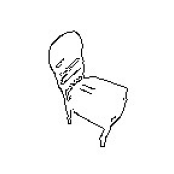

Mean distance: 0.003695149440318346


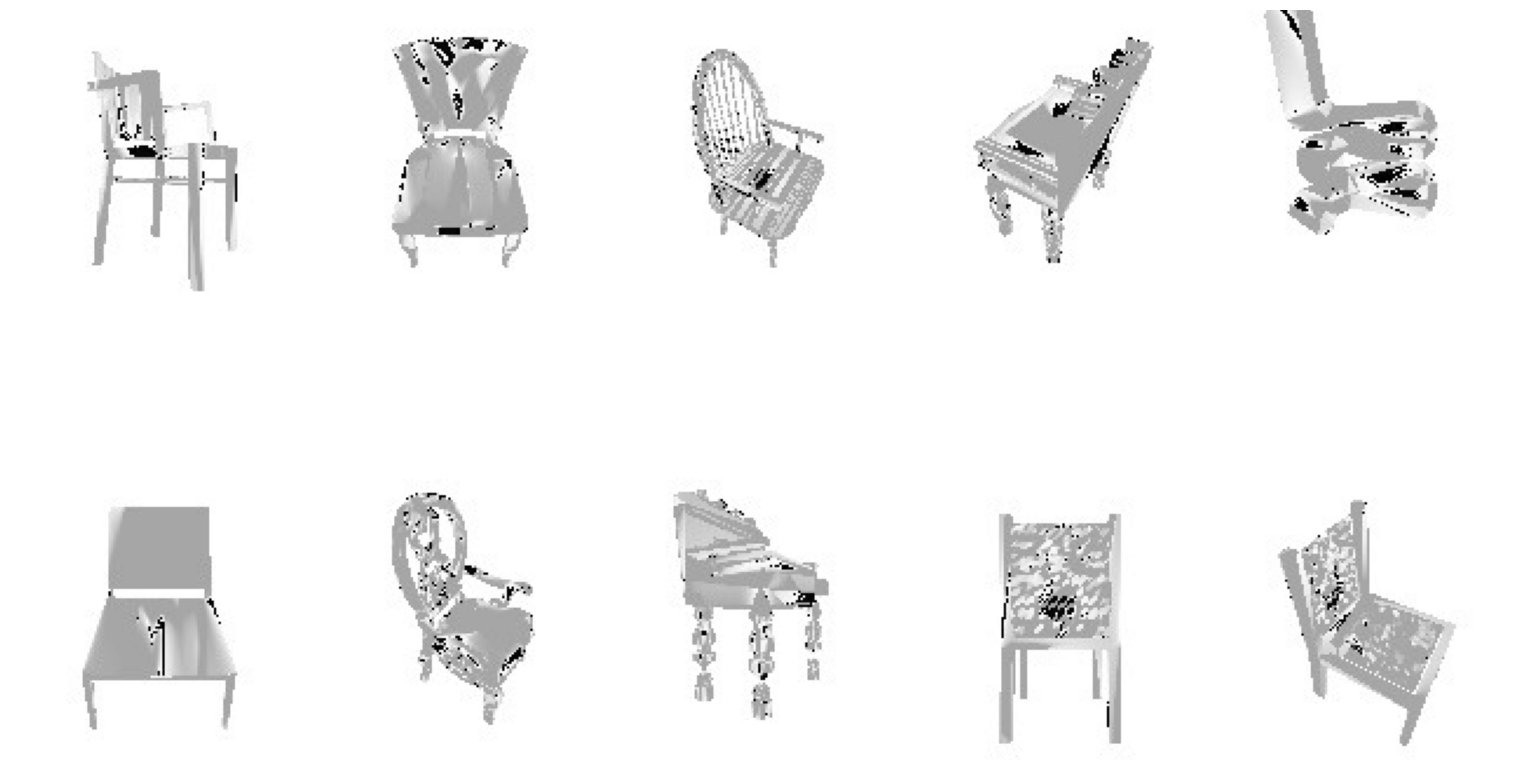

In [8]:
from lib.data.sketch import image_grid

def visualize_retrieval(idx, k: int = 10, query="sketch"):
    # visualize the sketch
    show_img = sketches[idx] if query == "sketch" else images[idx]
    sketch = np.transpose(show_img, (1, 2, 0))
    sketch = np.clip(sketch, 0, 1)
    plt.figure(figsize=(2,2))
    plt.imshow(sketch)
    plt.axis('off')
    plt.show()

    # visualize the response
    embs = sketches_emb[idx:idx+1] if query == "sketch" else images_emb[idx:idx+1] 
    D, I = index.search(embs, k)     # actual search
    print(f"Mean distance: {D.mean()}")
    retrieved_images = np.array(images[I] * 255, dtype=np.uint8)
    retrieved_images = np.transpose(retrieved_images, (0, 2, 3, 1))
    image_grid(retrieved_images, rows=2, cols=5)

# visualize_retrieval(20, query="image")
visualize_retrieval(50, query="sketch")

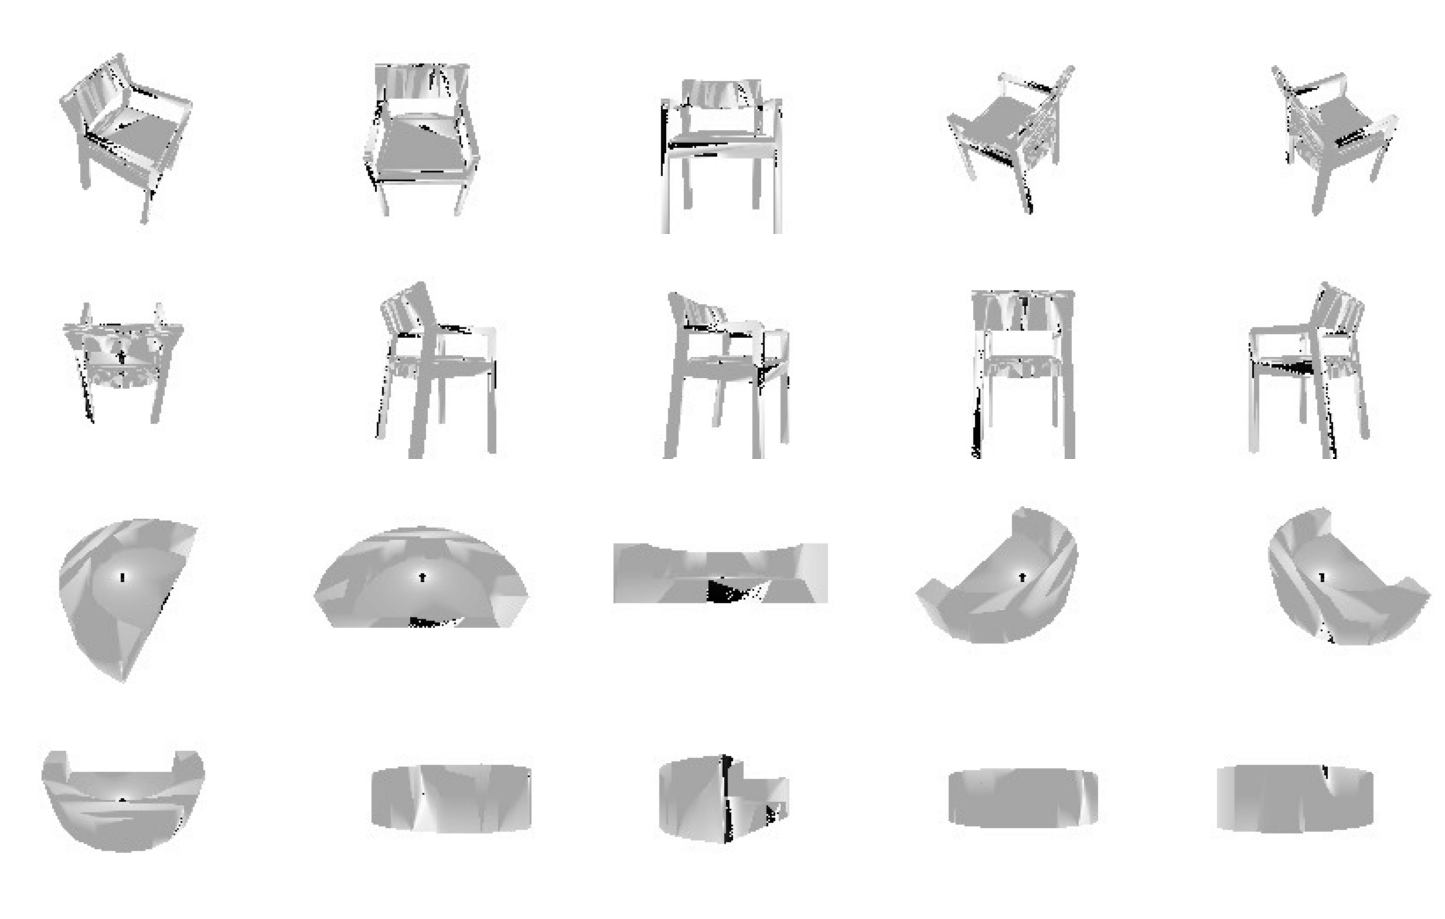

In [149]:
# visualize chairs 
retrieved_images = np.array(images[20:40] * 255, dtype=np.uint8)
retrieved_images = np.transpose(retrieved_images, (0, 2, 3, 1))
image_grid(retrieved_images, rows=4, cols=5)

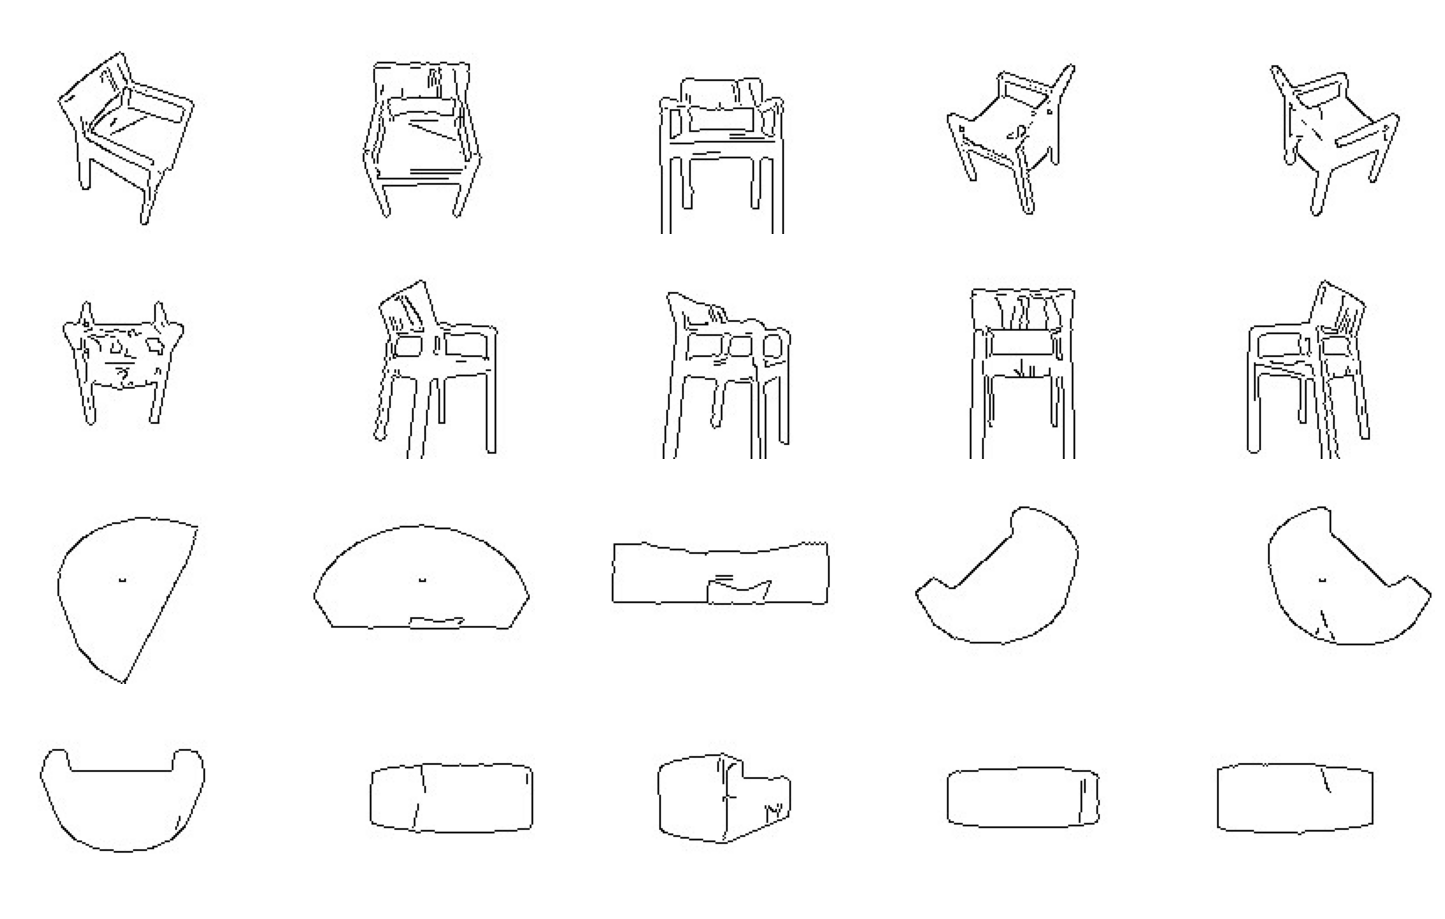

In [150]:
# visualize sketches 
retrieved_images = np.array(sketches[20:40] * 255, dtype=np.uint8)
retrieved_images = np.transpose(retrieved_images, (0, 2, 3, 1))
image_grid(retrieved_images, rows=4, cols=5)

In [158]:
images_emb.mean(axis=1)[:10]

array([0.06674808, 0.06575154, 0.06598417, 0.06565851, 0.06571178,
       0.06597627, 0.06624636, 0.06633083, 0.06533768, 0.06544053],
      dtype=float32)

In [159]:
images_emb.mean(axis=1)[10:20]

array([0.0667627 , 0.06635369, 0.06434914, 0.06605943, 0.06660225,
       0.06489556, 0.06544609, 0.0650057 , 0.06616691, 0.06546681],
      dtype=float32)

In [160]:
images_emb.mean(axis=1)[20:30]

array([0.06622338, 0.06596284, 0.06575766, 0.06650342, 0.0661287 ,
       0.06612588, 0.06631991, 0.0661766 , 0.06480477, 0.06773084],
      dtype=float32)